# GST Tutorial
* This tutorial is adapted and customized from: https://github.com/google/Xee/tree/main/examples
* Also, see this for more details on Xee: https://www.linkedin.com/pulse/xee-geospatial-analysis-made-easier-tutorial-code-ali-ahmadalipour-7esgc/
* If your python environment doesn't have all the packages then please install them

In [1]:
# all these below packages can be installed by running the cell below (un-comment the code line and run)
# it may take a few or more minutes to install all these packages

!pip install xarray matplotlib numpy pandas datetime dask geopandas xarray xee google ee requests rioxarray

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import geopandas as gpd
import xarray as xr
import xee
from io import StringIO
import google
import requests

In [3]:
# for this we need multi-processing, we use dask
# starting dask for multi-processing:
import dask.distributed
client = dask.distributed.Client(n_workers=4)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 8.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:50880,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 8.00 GiB
Comm: tcp://127.0.0.1:50891,Total threads: 1
Dashboard: http://127.0.0.1:50893/status,Memory: 2.00 GiB
Nanny: tcp://127.0.0.1:50883,


## Initialise Google `Earth Engine`
* Note: after running the cell below, you will be prompted to complete the authorisation using your google account to access data directly from google developers cloud platform (i.e., Earth Engine)
* In some cases, an automatic authentication window doesn't appear, in that case, open the link (will appear below) by clicking it or copy/paste it to your browser
* Follow the steps: (1) generate token, (2) continue ahead, (3) mark `Select all` services and (4) continue, a security text/code will appear, (5) copy it and (6) paste it back into in this notebook (a pasting space will appear after following the steps) and (7) press `Enter`. Authentication will be done.
* `Successfully saved authorization token.` message will appear after successful authentication.

In [4]:
import ee
ee.Authenticate()

True

In [5]:
ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')

## Define ROI

In [6]:
# In the below URL, Himalayan subregion outlines (from Shean et al. 2020) are stored
# https://osf.io/4vmnw/
# from there, download the file directly and access it here
# it may take a minute or two to download
url = "https://osf.io/download/sh84z/"
local_filename = "boundary_mountain_regions_hma_v3_clean.gpkg"

# download the file
response = requests.get(url)
with open(local_filename, 'wb') as f:
    f.write(response.content)

# read
himap_reg = gpd.read_file(local_filename)
# himap_reg = gpd.read_file('boundary_mountain_regions_hma_v3_clean.gpkg') # this is direct method when you have the file

In [7]:
# lets say for easiness we retrieve GST for a subregion of Himalaya
# define the ROI (e.g., Karakoram)
roi = himap_reg[himap_reg.himap_region == 'Karakoram']

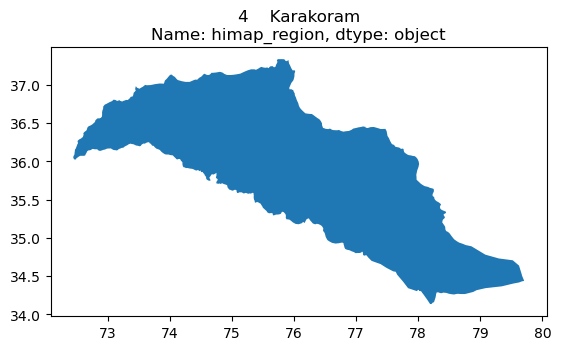

In [8]:
# quickly check if the ROI is correct or not
roi.plot()
plt.title(f'{roi.himap_region}')
plt.show()

#### Extract ROI glaciers for clipping to glacier outlines, later on

In [9]:
# hma glacier outlines (credit: RGI)
# same method as above
url = "https://osf.io/download/8jhk7/"
local_filename = "14_rgi60_SouthAsiaWest.gpkg"

# download the file
response = requests.get(url)
with open(local_filename, 'wb') as f:
    f.write(response.content)

hma_glac = gpd.read_file(local_filename)
# hma_glac = gpd.read_file('14_rgi60_SouthAsiaWest.shp')

# assign a coordinate system
hma_glac = hma_glac.to_crs(epsg=4326)

# select glacier within roi
# https://oggm.org/tutorials/stable/notebooks/beginner/working_with_rgi.html
import shapely.geometry as shpg
in_bas = [roi.geometry.apply(lambda geom: geom.contains(shpg.Point(x, y))).any() for (x, y) in zip(hma_glac.CenLon, hma_glac.CenLat)]
roi_glac = hma_glac.loc[in_bas]

## Import data from `GEE` Data Catalog
* https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MOD11A2

In [10]:
roi_bounds = roi.total_bounds
buffer = 0.1 # we add a buffer to cover entire data
roi_bounds = [
    roi_bounds[0] - buffer,
    roi_bounds[1] - buffer,
    roi_bounds[2] + buffer,
    roi_bounds[3] + buffer
]

In [11]:
# we download MODIS Terra satellite data
# MOD: Terra, MYD: Aqua satellites
ic = (
    ee.ImageCollection('MODIS/061/MOD11A2')
    .filterDate('2023-10-01', '2024-09-30')
    .select('LST_Day_1km', 'QC_Day', 'LST_Night_1km', 'QC_Night')
)

region = ee.Geometry.Rectangle(*roi_bounds)
ds = xr.open_dataset(ic,
                     engine='ee',
                     crs='EPSG:4326',
                     scale=0.012,
                     geometry=region)

* Note here that for time and ease, we are accessing data only for the hydrological year 2023-2024 (1 Oct 2023 - 30 Sep 2024), and accessing both daytime and nighttime data from MODIS
* From here: https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MOD11A2

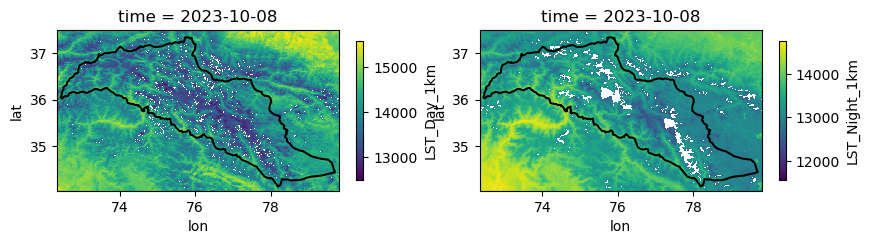

In [12]:
# quick plot
fig, ax = plt.subplots(ncols=2, figsize=(10,6))

ds.LST_Day_1km[0].T.plot(ax=ax[0], cbar_kwargs={'shrink': 0.3})
ds.LST_Night_1km[0].T.plot(ax=ax[1], cbar_kwargs={'shrink': 0.3})

roi.boundary.plot(ax=ax[0], color='k')
roi.boundary.plot(ax=ax[1], color='k')
plt.show()

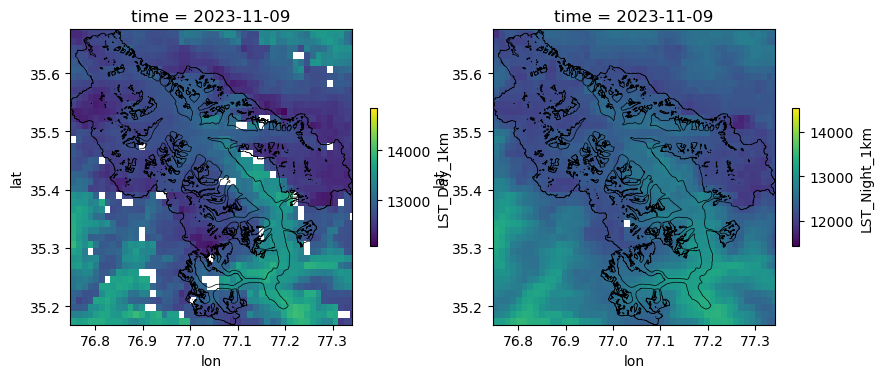

In [13]:
# lets zoom to a specific glacier
example_glac = hma_glac[hma_glac.RGIId == 'RGI60-14.07524'] # siachen glacier
xmin, ymin, xmax, ymax = example_glac.geometry.total_bounds # siachen glacier boundaries

# plot
fig, ax = plt.subplots(ncols=2, figsize=(10,6))

ds.LST_Day_1km[4].T.plot(ax=ax[0], cbar_kwargs={'shrink': 0.3})
ds.LST_Night_1km[4].T.plot(ax=ax[1], cbar_kwargs={'shrink': 0.3})
example_glac.boundary.plot(ax=ax[0], color='k', linewidth=0.5)
example_glac.boundary.plot(ax=ax[1], color='k', linewidth=0.5)

ax[0].set_xlim(xmin, xmax)
ax[0].set_ylim(ymin, ymax)
ax[1].set_xlim(xmin, xmax)
ax[1].set_ylim(ymin, ymax)

plt.show()

In [14]:
# remove questionable GST pixel values
# filter and retain the quality controlled values following below article
# https://doi.org/10.1029/2022GL101115 (Sect 2.1)
valid_qc_values = [64, 65, 128, 129]

# create a mask where QC_Day and QC_Night has valid values
qc_mask_d = ds['QC_Day'].isin(valid_qc_values)
qc_mask_n = ds['QC_Night'].isin(valid_qc_values)

# apply the mask to LSTs
filtered_lst_d = ds['LST_Day_1km'].where(qc_mask_d)
filtered_lst_n = ds['LST_Night_1km'].where(qc_mask_n)

# add the filtered data back to the dataset
ds['Filtered_LST_Day_1km'] = filtered_lst_d
ds['Filtered_LST_Night_1km'] = filtered_lst_n

In [15]:
# sepearte the daytime and nighttime GSTs
gst_day = ds['Filtered_LST_Day_1km']
gst_night = ds['Filtered_LST_Night_1km']

In [16]:
# if you see above plots, LST values are unrealistic (too high, becasue they are scaled)
# see here: https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MOD11A2#bands
# so, lets convert them to Kelvin
gst_day_k = gst_day * 0.02
gst_day_k = gst_day_k.where((gst_day >= 7500) & (gst_day <= 16000), np.nan)

gst_night_k = gst_night * 0.02
gst_night_k = gst_night_k.where((gst_night >= 7500) & (gst_night <= 16000), np.nan)

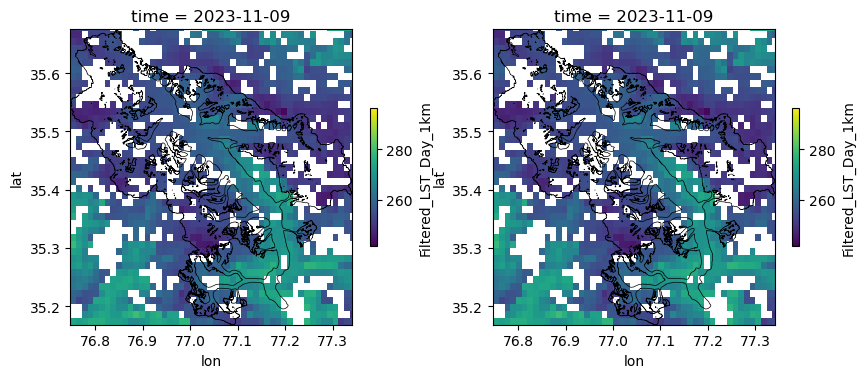

In [17]:
# re-plot again
fig, ax = plt.subplots(ncols=2, figsize=(10,6))

gst_day_k[4].T.plot(ax=ax[0], cbar_kwargs={'shrink': 0.3})
gst_day_k[4].T.plot(ax=ax[1], cbar_kwargs={'shrink': 0.3})
example_glac.boundary.plot(ax=ax[0], color='k', linewidth=0.5)
example_glac.boundary.plot(ax=ax[1], color='k', linewidth=0.5)

ax[0].set_xlim(xmin, xmax)
ax[0].set_ylim(ymin, ymax)
ax[1].set_xlim(xmin, xmax)
ax[1].set_ylim(ymin, ymax)

plt.show()

* Compare the above maps to the previous (without filtering maps), several unexpected pixels got discarded.
* What we have now is the (8-day) timeseries of quality MODIS GST data - ready for further analysis.

## Now, create GST (Glacier Surface Temeprature)
* Basically, we clip the LSTs within glacier boundaries (RGI)

In [18]:
# we need to rename the coordinates for clipping
gst_day_k = gst_day_k.rename({"lat": "y", "lon": "x"})
gst_night_k = gst_night_k.rename({"lat": "y", "lon": "x"})

In [19]:
# clipping to galcier outlines = GST
gst_day_k.rio.write_crs(roi_glac.crs, inplace=True);
gst_day_k_clip = gst_day_k.rio.clip(roi_glac.geometry, crs=roi_glac.crs, drop=True, invert=False);

gst_night_k.rio.write_crs(roi_glac.crs, inplace=True);
gst_night_k_clip = gst_night_k.rio.clip(roi_glac.geometry, crs=roi_glac.crs, drop=True, invert=False);

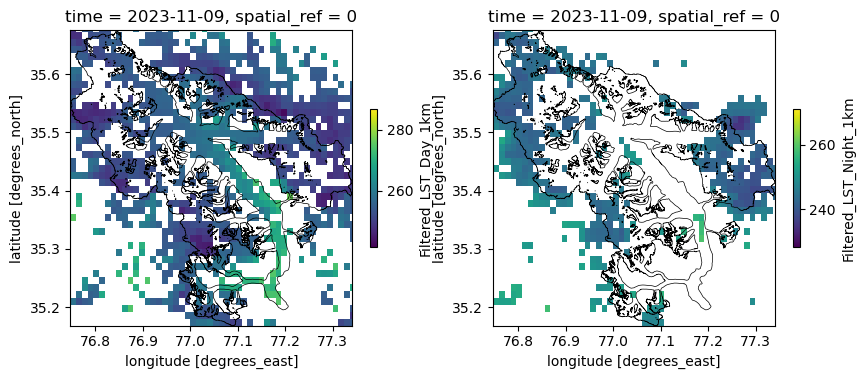

In [20]:
# plot GSTs
fig, ax = plt.subplots(ncols=2, figsize=(10,6))

gst_day_k_clip[4].T.plot(ax=ax[0], cbar_kwargs={'shrink': 0.3})
gst_night_k_clip[4].T.plot(ax=ax[1], cbar_kwargs={'shrink': 0.3})
example_glac.boundary.plot(ax=ax[0], color='k', linewidth=0.5)
example_glac.boundary.plot(ax=ax[1], color='k', linewidth=0.5)

ax[0].set_xlim(xmin, xmax)
ax[0].set_ylim(ymin, ymax)
ax[1].set_xlim(xmin, xmax)
ax[1].set_ylim(ymin, ymax)

plt.show()

* Note here that only LST pixels over glacier outline (all Karakroram glaciers) remains after clipping and filtering
* AND, now we have filtered GST timeseries in hand ready for analysis
* HERE, you might ask: why there are some pixels outside the glacier boundary? Ans: note that in the above plot, I just used Siachen Glacier's outline, so there might be other glacier around and therefore in this plot you can see some pixels outside the boundary. Run the cell below, with all glacier outline, it will be clear.

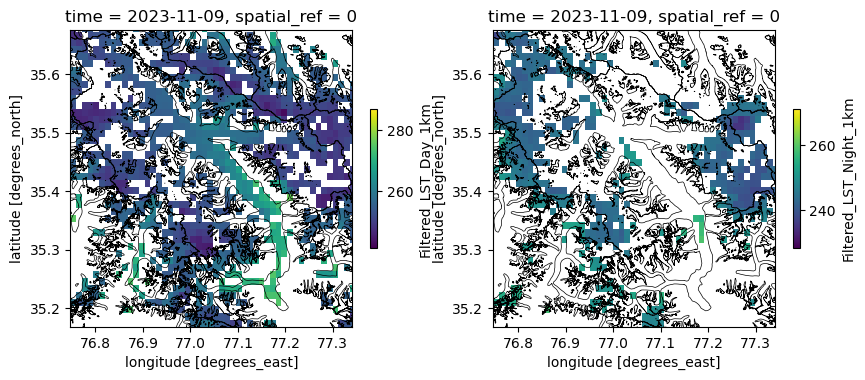

In [21]:
# plot GSTs with all glacier boundary
fig, ax = plt.subplots(ncols=2, figsize=(10,6))

gst_day_k_clip[4].T.plot(ax=ax[0], cbar_kwargs={'shrink': 0.3})
gst_night_k_clip[4].T.plot(ax=ax[1], cbar_kwargs={'shrink': 0.3})
roi_glac.boundary.plot(ax=ax[0], color='k', linewidth=0.5)
roi_glac.boundary.plot(ax=ax[1], color='k', linewidth=0.5)

ax[0].set_xlim(xmin, xmax)
ax[0].set_ylim(ymin, ymax)
ax[1].set_xlim(xmin, xmax)
ax[1].set_ylim(ymin, ymax)

plt.show()

## We can do some quick analysis/stats or visualisation

#### Monthly climatology of GST

In [22]:
# mean monthly aggregation
ds_d_clip_monthly = gst_day_k_clip.mean(dim=('x', 'y')).resample(time='1M').mean()
ds_d_clip_monthly = ds_d_clip_monthly.to_dataframe()

ds_n_clip_monthly = gst_night_k_clip.mean(dim=('x', 'y')).resample(time='1M').mean()
ds_n_clip_monthly = ds_n_clip_monthly.to_dataframe()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


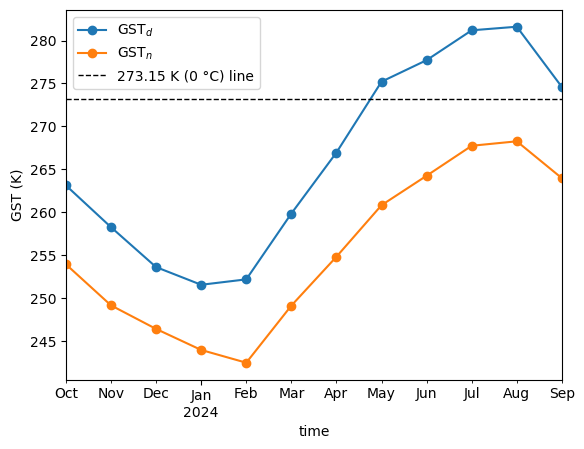

In [29]:
ds_d_clip_monthly.Filtered_LST_Day_1km.plot(marker='o', label='GST$_d$') # daytime
ds_n_clip_monthly.Filtered_LST_Night_1km.plot(marker='o', label='GST$_n$') # nighttime
plt.axhline(y=273.15, label='273.15 K (0 °C) line', linestyle='--', color='k', linewidth=1)
plt.ylabel('GST (K)')
plt.legend()
plt.show()

#### Monthly climatology map of GST

In [24]:
# first, resample the data to monthly frequency and compute the mean
gst_d_monthly_avg = gst_day_k_clip.resample(time='1M').mean(dim='time')

* Below plot will give you GST map (GST climatology; spatial) for all 12 months

/var/folders/zl/kj4vnv4j3md29yc30fwf6ry00000gn/T/ipykernel_1335/1309822600.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # adjust layout to fit colorbar


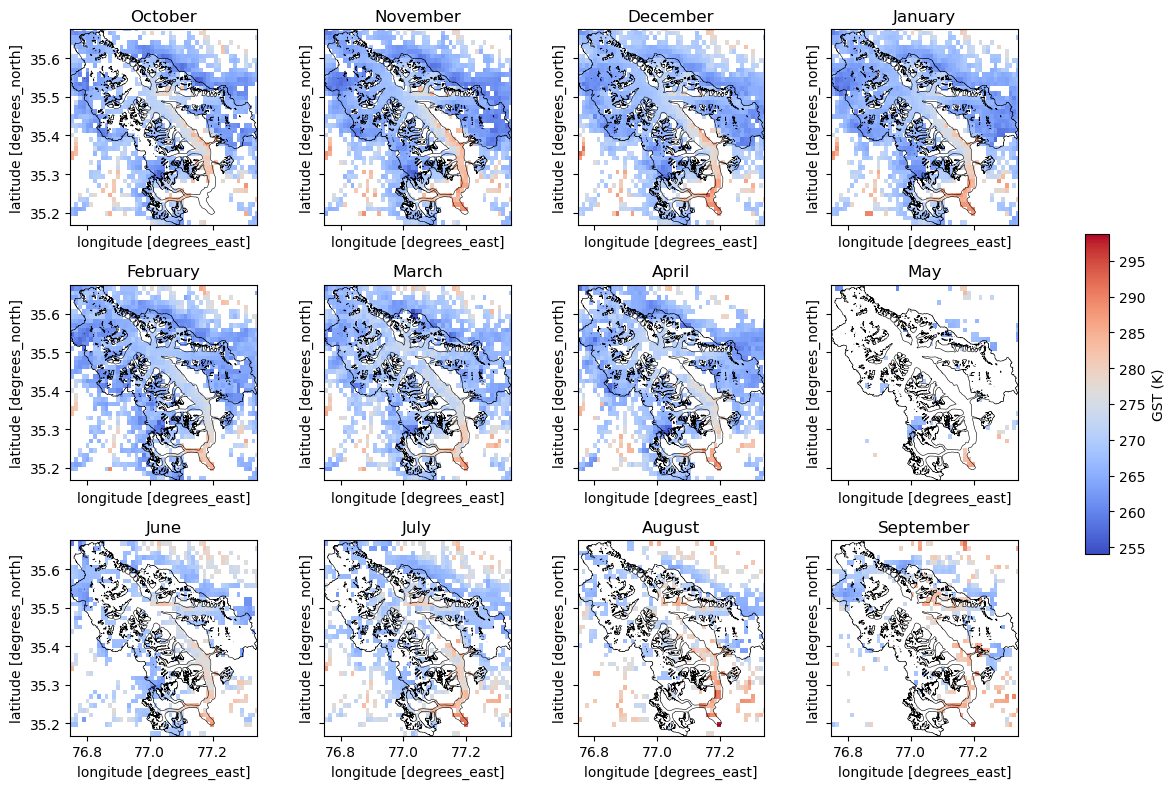

In [25]:
# plot
fig, axes = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True, figsize=(12,8))
axes = axes.flatten()

# loop through each month and plot
for i, time_val in enumerate(gst_d_monthly_avg.time):
    month_name = pd.to_datetime(time_val.values).strftime('%B')  # month name
    im = gst_d_monthly_avg.T.isel(time=i).plot(ax=axes[i], cmap='coolwarm', add_colorbar=False)
    axes[i].set_title(month_name)
    example_glac.boundary.plot(ax=axes[i], color='k', linewidth=0.4)
    axes[i].set_xlim(xmin, xmax)
    axes[i].set_ylim(ymin, ymax)

# colorbar
cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])  # adjust position: [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, label='GST (K)')

plt.tight_layout(rect=[0, 0, 0.9, 1])  # adjust layout to fit colorbar
plt.show()

* From the above plot, one can see that the summer months are warmer than winter months, particularly in the upper areas of the Siachen Glacier (example here)

* The time-series can be extended from 2000 to till date 

* Several other analysis such as trend analysis, elevation-wise GST changes, seasonality, extracting GST at an on-glacier AWS site and compare to AWS-based Ts estimates, can be done using this datasets.

## Thank you for trying out this tutorial.
## If you have any suggestion-feedback, please don't hesitate to write me: arindan.141@gmail.com

# -- end --